In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tifffile as tff
import ROI
import pandas as pd
import scipy.ndimage as ndi

## File path

In [2]:
filePath = '/Users/yungkuo/Google Drive/Oxford nanoimager/'
fileName = 'Shimon Weiss 9H 100ms 41deg Gr40.4694573205552839832_MMStack'

## Import movie 

In [3]:
tiffimg = tff.TiffFile(filePath+'converted tif/'+fileName+'.tif')
data = tiffimg.asarray().shape
frame = data[0]
movie = tiffimg.asarray()
dt = 0.1
T = np.arange(0, frame*dt, dt)
print 'movie size = {}'.format(data)

movie size = (500, 1024, 1024)


## Find points of interest (QDs)

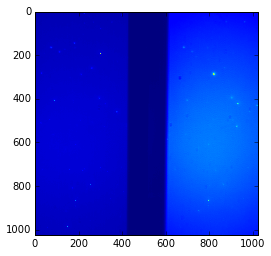

In [4]:
image = np.mean(movie, axis=0)
plt.imshow(image)

### highpass filter in space
### threshold map

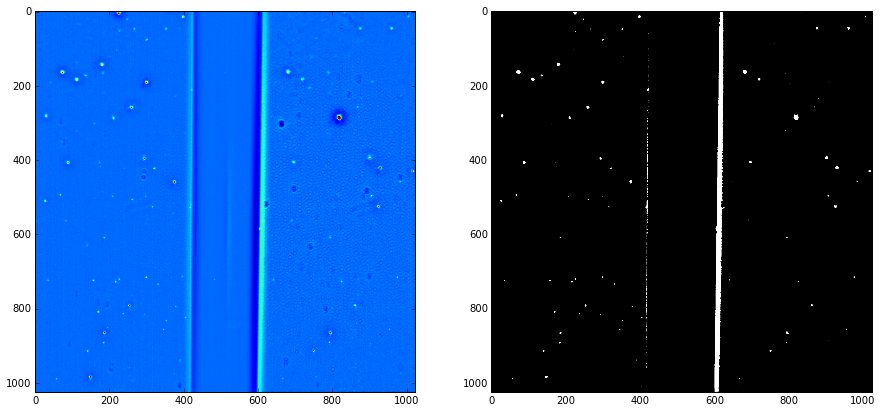

In [5]:
image_highpass = image - ndi.gaussian_filter(image, sigma=10)
th = image_highpass > 0.02*image_highpass.max()
fig, ax = plt.subplots(1,2, figsize=(15,10))
im = ax[0].imshow(image_highpass, vmax=0.2*image_highpass.max())
im = ax[1].imshow(th, cmap='gray')

### image x profile before and after HPF

mean of all pixels in image = 1099


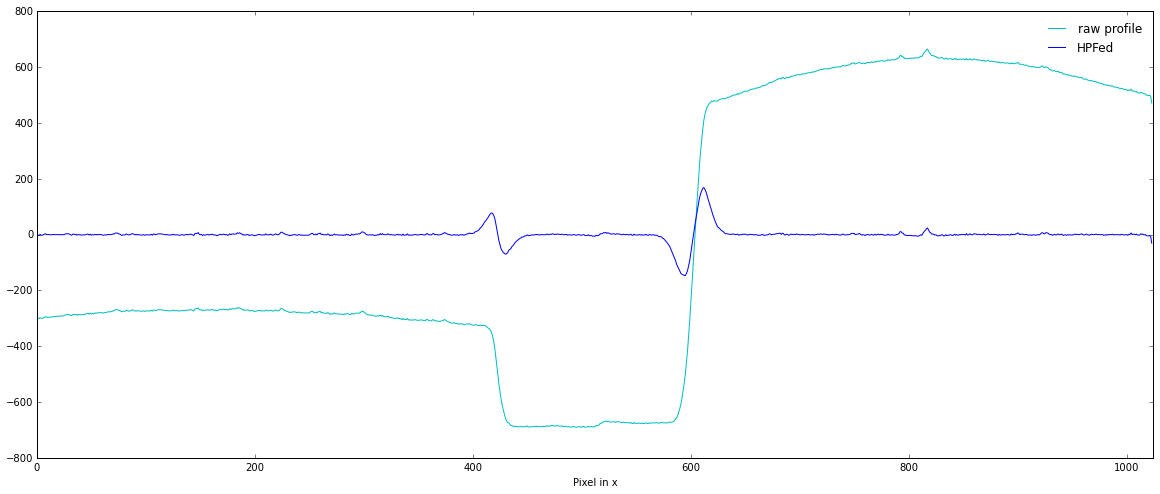

In [6]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(image.mean(0)-image.mean(), 'c', label='raw profile')
ax.plot(image_highpass.mean(0), 'b', label='HPFed')
#ax.plot(ndi.gaussian_filter(image, sigma=10).mean(0)-image.mean(),'m')
ax.set_xlim(0,1024)
ax.set_xlabel('Pixel in x')
ax.legend(frameon=False)
print 'mean of all pixels in image = %d' % image.mean()

### image y profile before and after HPF

mean of all pixels in image = 1099


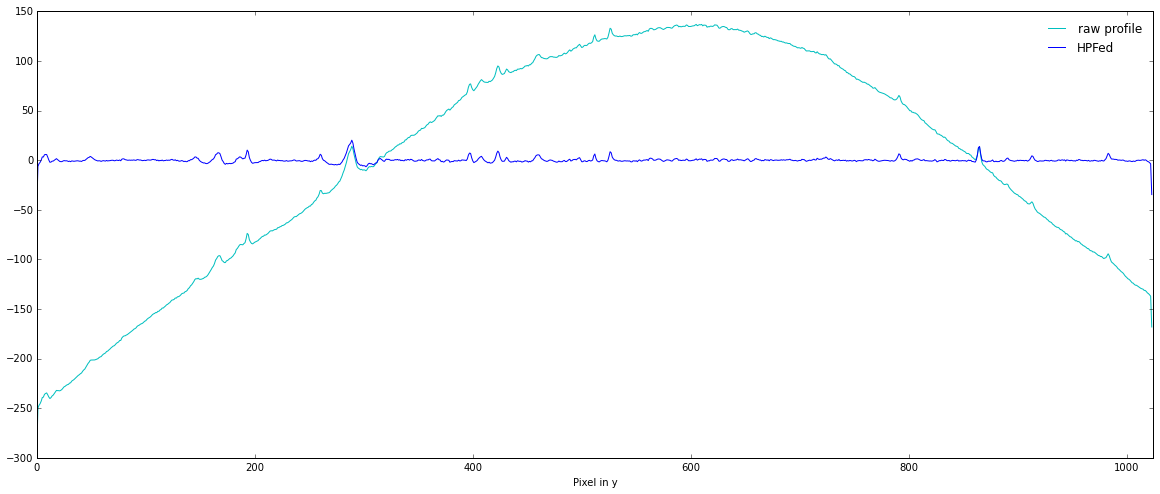

In [7]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(image.mean(1)-image.mean(), 'c', label='raw profile')
ax.plot(image_highpass.mean(1), 'b', label='HPFed')
#ax.plot(ndi.gaussian_filter(image, sigma=10).mean(0)-image.mean(),'m')
ax.set_xlim(0,1024)
ax.set_xlabel('Pixel in y')
ax.legend(frameon=False)
print 'mean of all pixels in image = %d' % image.mean()

# find QDs

In [8]:
scan = [4,4]
boundary = [10,400]
left_pts = ROI.findparticle(image_highpass, boundary, data, scan, nstd=1)
boundary=[620,1021]
right_pts = ROI.findparticle(image_highpass, boundary, data, scan, nstd=1)

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [9]:
print 'Number of QD in left view: {}'.format(len(left_pts))
print 'Number of QD in right view: {}'.format(len(right_pts))

Number of QD in left view: 66
Number of QD in right view: 43


### match left and right view

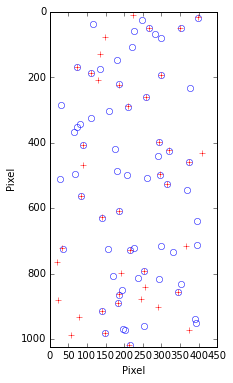

In [34]:
fig, ax = plt.subplots(figsize=(3,6))
for ip, pt in enumerate(left_pts):
    ax.plot(pt[0], pt[1], 'bo', fillstyle='none')
for ip, pt in enumerate(right_pts):
    ax.plot(pt[0]-boundary[0]+13, pt[1], 'r+')
ax.set_ylim(data[1],0)
ax.set_xlabel('Pixel')
ax.set_ylabel('Pixel')

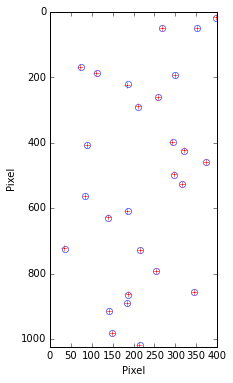

In [35]:
match = []
fig, ax = plt.subplots(figsize=(3,6))
for ipL, left_pt in enumerate(left_pts):
        for ipR, right_pt in enumerate(right_pts):
            if np.abs(right_pt[1] - left_pt[1]) < scan[1]:
                if np.abs(right_pt[0] - boundary[0]+13 -left_pt[0]) < scan[0]:
                    ax.plot(left_pt[0], left_pt[1], 'bo', fillstyle='none')
                    ax.plot(right_pt[0]-boundary[0]+13, right_pt[1], 'r+')
                    match1 = [ipL, ipR]
                    match = np.append(match, match1)
match = np.reshape(match, (len(match)/2,2))
ax.set_ylim(data[1],0)
ax.set_xlabel('Pixel')
ax.set_ylabel('Pixel')

### QDs show in both left and right view

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


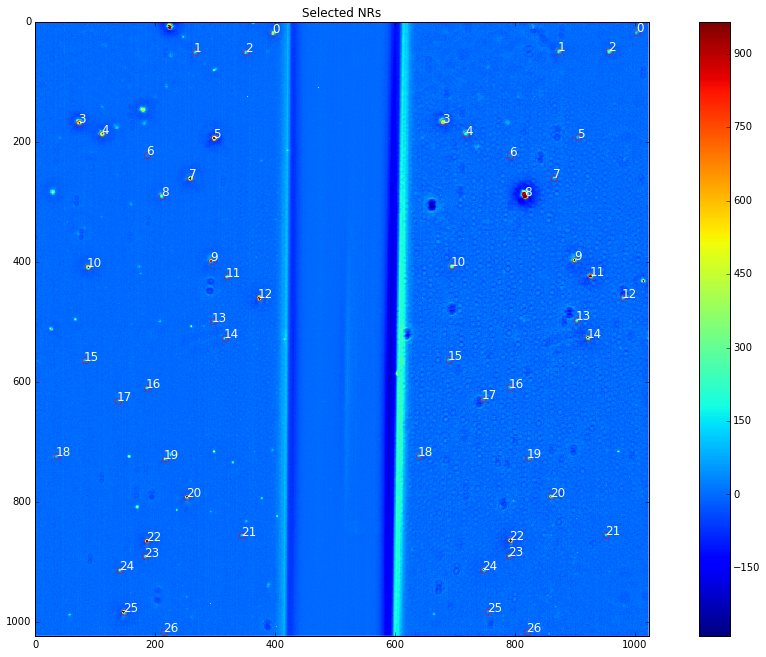

In [12]:
fig, ax = plt.subplots(figsize=(18, 11))
for ip, select in enumerate(match):
    plt.plot(left_pts[select[0]][0], left_pts[select[0]][1], 'ro', fillstyle='none')
    plt.annotate('%d' % ip, left_pts[select[0]], color='white', fontsize=12)

    plt.plot(right_pts[select[1]][0], right_pts[select[1]][1], 'ro', fillstyle='none')
    plt.annotate('%d' % ip, right_pts[select[1]], color='white', fontsize=12)
im = ax.imshow(image_highpass, interpolation='none', vmax=0.2*image_highpass.max())
plt.colorbar(im);
ax.set_title('Selected NRs')

### Left view QDs

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


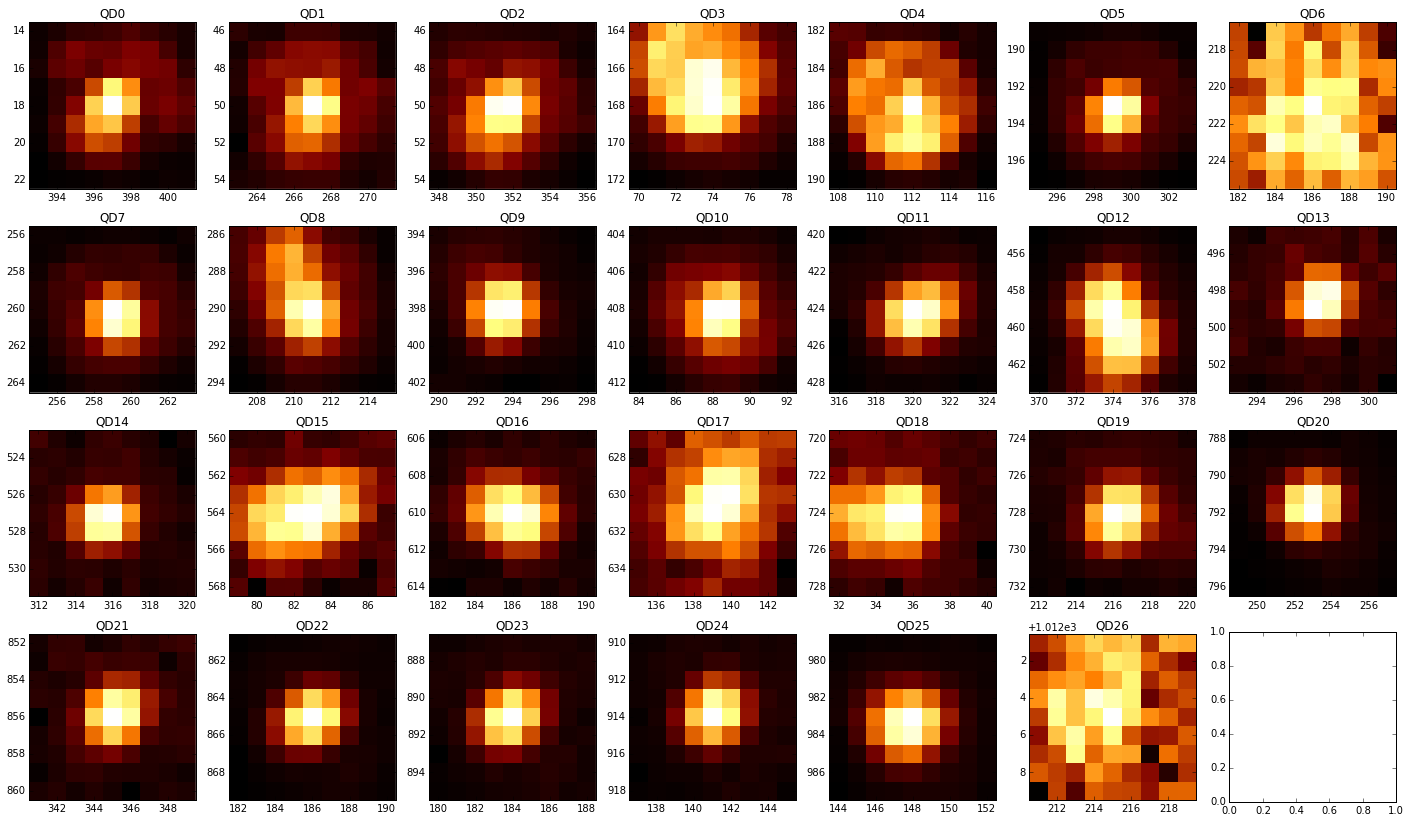

In [13]:
pad = scan
nrows = 4
npoints = len(match)
even_npoints = npoints if npoints % 2 == 0 else npoints + 1
ncols = even_npoints // nrows

fig, ax = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3.5*nrows))
axr = ax.ravel()
for ip, select in enumerate(match):
    roi = ROI.get_roi_square(left_pts[select[0]],pad)
    axr[ip].imshow(image[roi], cmap='afmhot', interpolation='none',
                     extent=(roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5))
    axr[ip].set_title('QD{}'.format(ip))

### Right view QDs

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


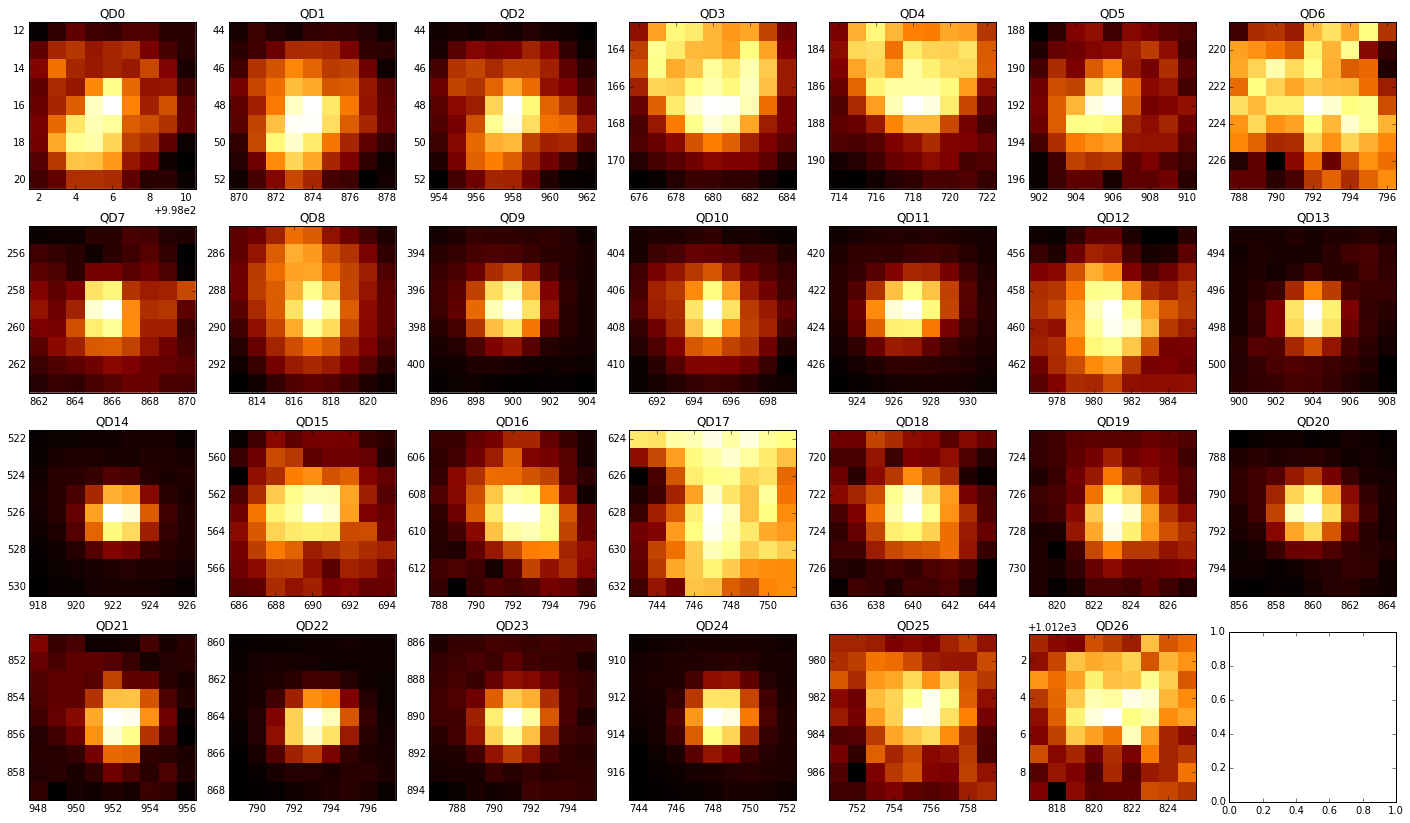

In [14]:
pad = np.array(scan)
nrows = 4
npoints = len(match)
even_npoints = npoints if npoints % 2 == 0 else npoints + 1
ncols = even_npoints // nrows

fig, ax = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3.5*nrows))
axr = ax.ravel()
for ip, select in enumerate(match):
    roi = ROI.get_roi_square(right_pts[select[1]],pad)
    axr[ip].imshow(image[roi], cmap='afmhot', interpolation='none',
                     extent=(roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5))
    axr[ip].set_title('QD{}'.format(ip))

### Exam PSF in left and right view

##### X profile

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


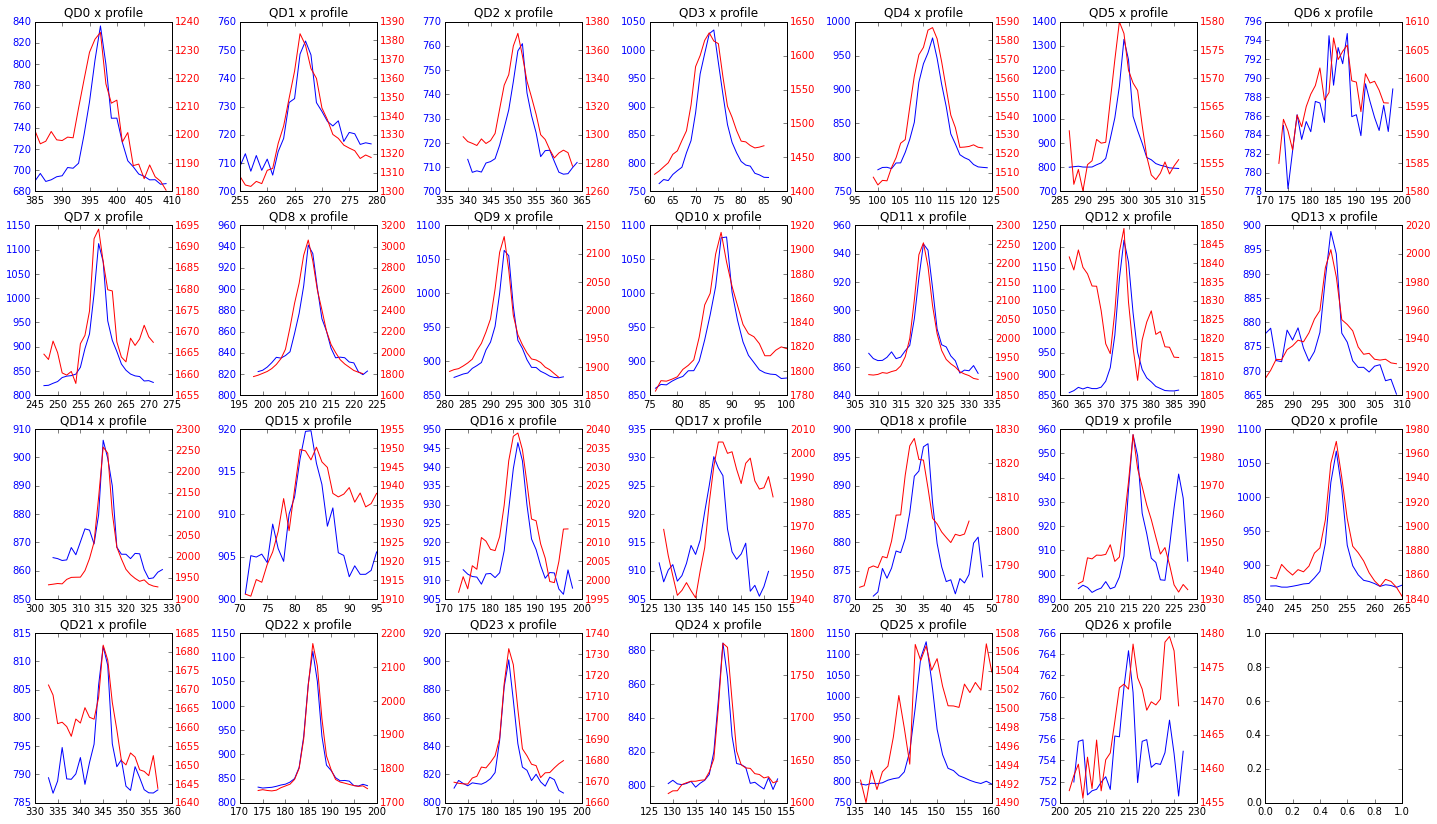

In [15]:
pad = np.array(scan)*3
nrows = 4
npoints = len(match)
even_npoints = npoints if npoints % 2 == 0 else npoints + 1
ncols = even_npoints // nrows

fig, ax = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3.5*nrows))
axr = ax.ravel()
for ip, select in enumerate(match):
    roi = ROI.get_roi_square(left_pts[select[0]],pad)
    axr[ip].plot(np.arange(roi[1].start, roi[1].stop, 1), image[roi].mean(0),'b')
    for tl in axr[ip].get_yticklabels():
        tl.set_color('b')
    
    roi = ROI.get_roi_square(right_pts[select[1]],pad)
    ax2 = axr[ip].twinx()
    ax2.plot(np.arange(roi[1].start, roi[1].stop, 1)-boundary[0]+13, image[roi].mean(0), 'r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    
    axr[ip].set_title('QD{} x profile'.format(ip))
    fig.subplots_adjust(wspace=0.5, hspace=0.2)

##### Y profile

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


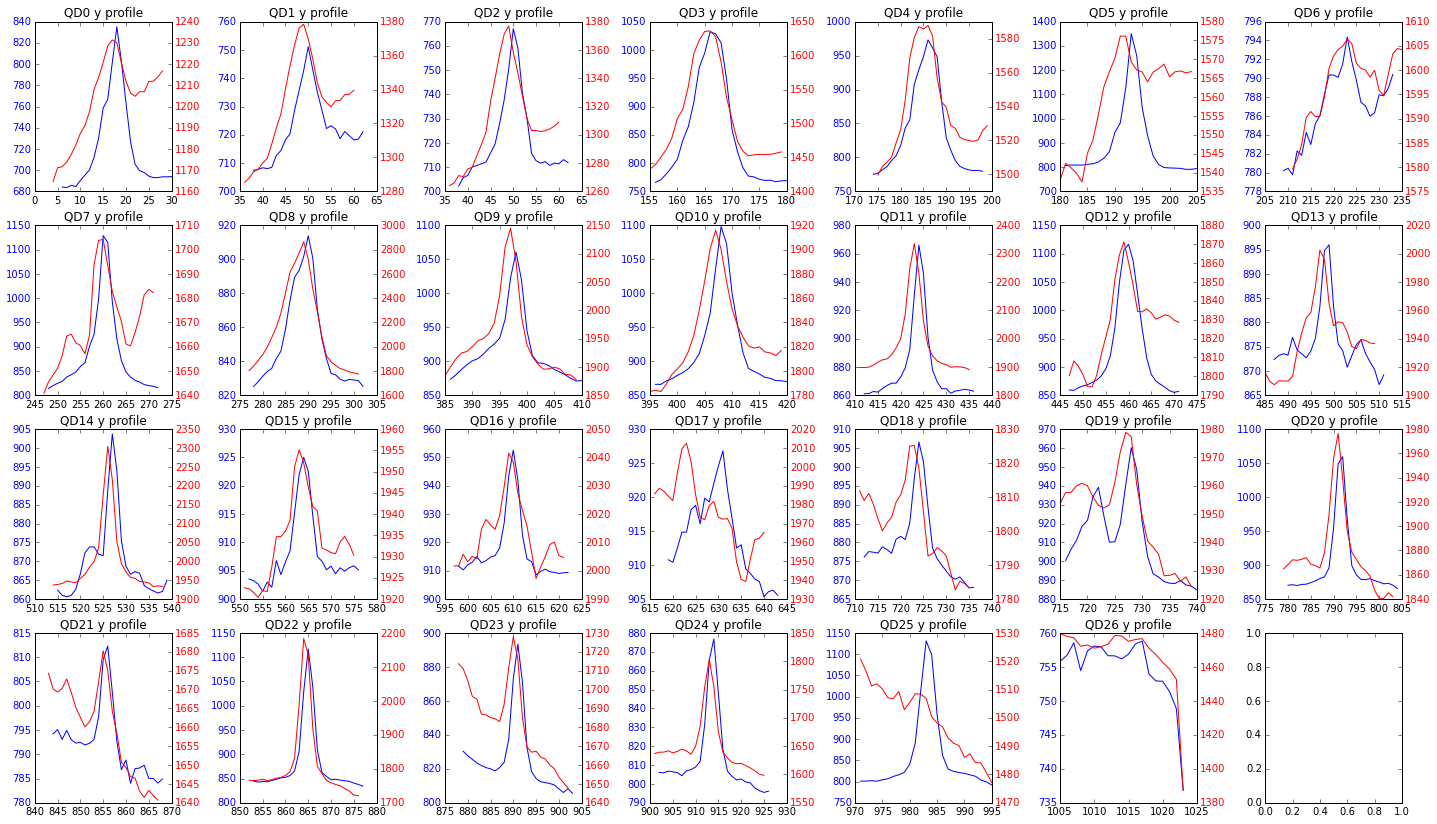

In [16]:
pad = np.array(scan)*3
nrows = 4
npoints = len(match)
even_npoints = npoints if npoints % 2 == 0 else npoints + 1
ncols = even_npoints // nrows

fig, ax = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3.5*nrows))
axr = ax.ravel()
for ip, select in enumerate(match):
    roi = ROI.get_roi_square(left_pts[select[0]],pad)
    axr[ip].plot(np.arange(roi[0].start, min(roi[0].stop,data[2]), 1), image[roi].mean(1),'b')
    for tl in axr[ip].get_yticklabels():
        tl.set_color('b')
    
    roi = ROI.get_roi_square(right_pts[select[1]],pad)
    ax2 = axr[ip].twinx()
    ax2.plot(np.arange(roi[0].start, min(roi[0].stop,data[2]), 1), image[roi].mean(1), 'r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    
    axr[ip].set_title('QD{} y profile'.format(ip))
    fig.subplots_adjust(wspace=0.5, hspace=0.2)

## Extract QD blinking timetrace

1. Background subtraction  
2. Extract timetrace  
3. Plot "left / right" ratio

In [17]:
pad = np.array(scan)*3
Ltt = pd.DataFrame()
Rtt = pd.DataFrame()
for ip, select in enumerate(match):
    ltt = ROI.get_timetrace_square(movie, left_pts[select[0]], scan)
    rtt = ROI.get_timetrace_square(movie, right_pts[select[1]], scan)
    lbg = 1/float((pad[0]*(pad[1]+1))-(scan[0]*(scan[1]+1)))*(ROI.get_timetrace_square(movie, left_pts[select[0]], pad)
                                                              *(pad[0]*(pad[1]+1))-ltt*(scan[0]*(scan[1]+1)))
    rbg = 1/float((pad[0]*(pad[1]+1))-(scan[0]*(scan[1]+1)))*(ROI.get_timetrace_square(movie, right_pts[select[1]], pad)
                                                              *(pad[0]*(pad[1]+1))-rtt*(scan[0]*(scan[1]+1)))
  
    ltt = ltt - lbg
    rtt = rtt - rbg
    Ltt[ip] = ltt
    Rtt[ip] = rtt

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


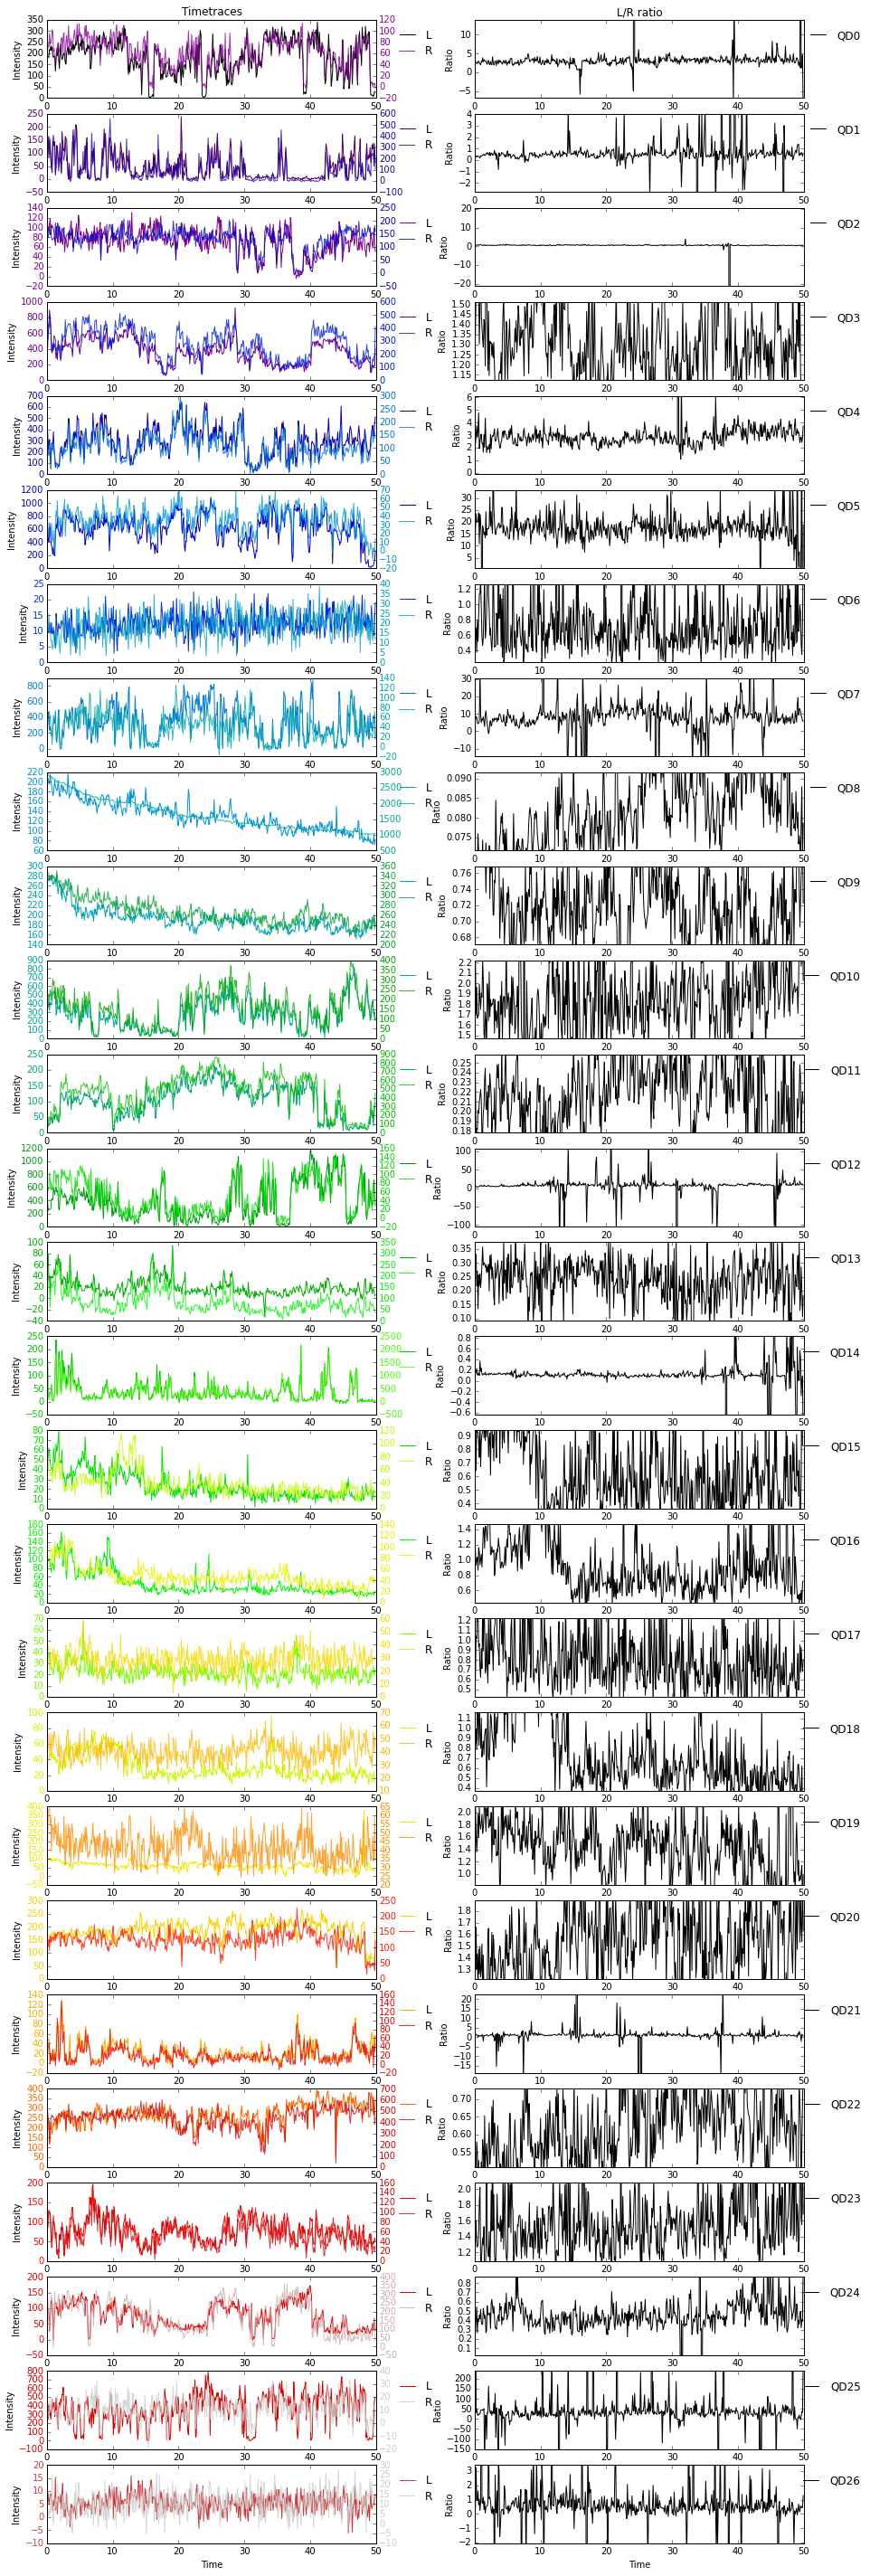

In [37]:
cmap = matplotlib.cm.get_cmap('nipy_spectral')
fig, ax = plt.subplots(len(match),2, figsize=(15,50))
for ip in range(len(match)):
    ax[ip,0].plot(T,Ltt[ip],c=cmap(float(ip)/len(match)), label='L')
    ax2 = ax[ip,0].twinx()
    ax2.plot(T,Rtt[ip],c=cmap(float(ip)/len(match)+0.1), label='R', alpha=0.8)
    for tl in ax[ip,0].get_yticklabels():
        tl.set_color(cmap(float(ip)/len(match)))
    for tl in ax2.get_yticklabels():
        tl.set_color(cmap(float(ip)/len(match)+0.1))
    ax[ip,1].plot(T,Ltt[ip]/Rtt[ip],c='k', label='QD%d' % ip)
    ax[ip,0].legend(frameon=False, bbox_to_anchor=(1.2,1))
    ax[ip,0].set_ylabel('Intensity')
    ax2.legend(frameon=False, bbox_to_anchor=(1.2,0.8))
    ax[ip,1].legend(frameon=False, bbox_to_anchor=(1.2,1))
    ax[ip,1].set_ylim(np.mean(Ltt[ip]/Rtt[ip])-np.std(Ltt[ip]/Rtt[ip]), np.mean(Ltt[ip]/Rtt[ip])+np.std(Ltt[ip]/Rtt[ip]))
    ax[ip,1].set_ylabel('Ratio')
    fig.subplots_adjust(wspace=0.3)
    
ax[0,0].set_title('Timetraces')
ax[0,1].set_title('L/R ratio')
ax[ip,0].set_xlabel('Time')
ax[ip,1].set_xlabel('Time')

### blinking threshold

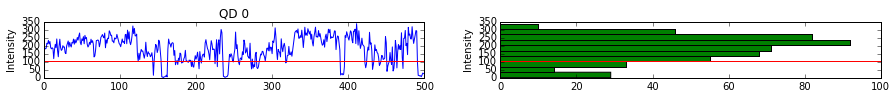

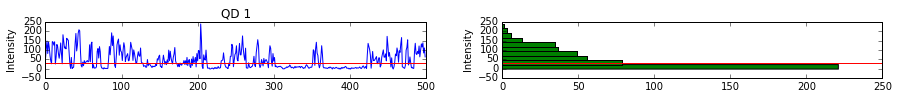

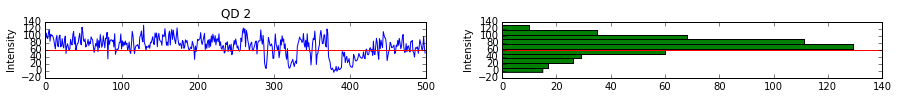

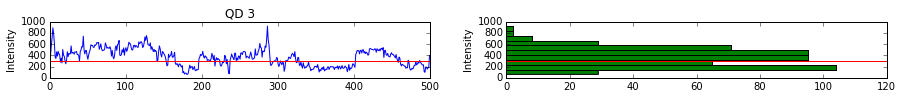

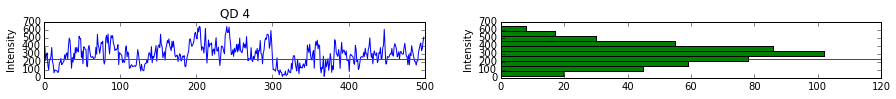

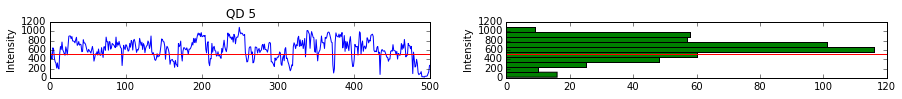

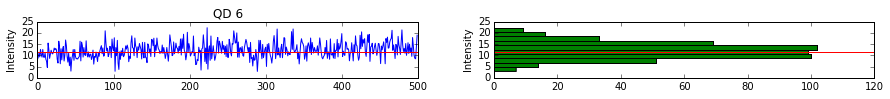

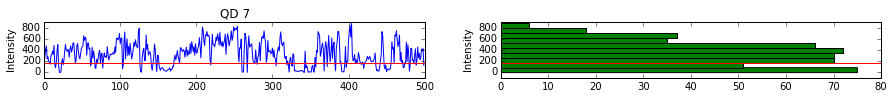

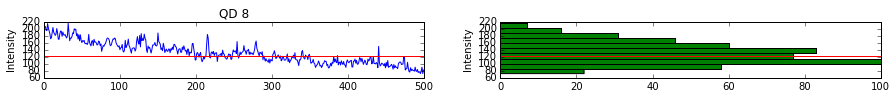

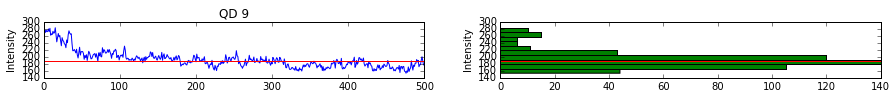

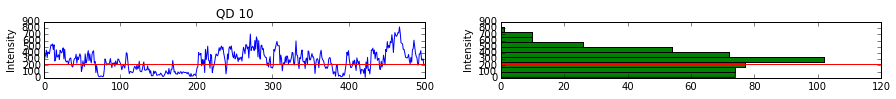

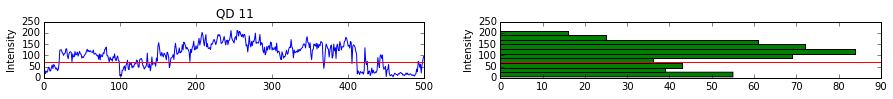

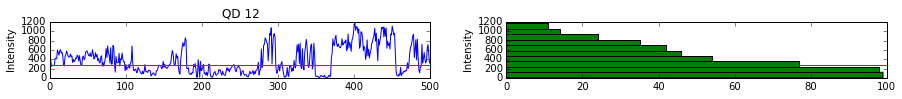

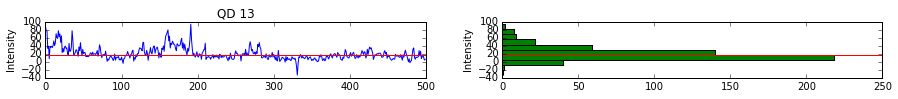

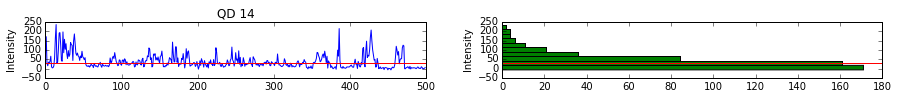

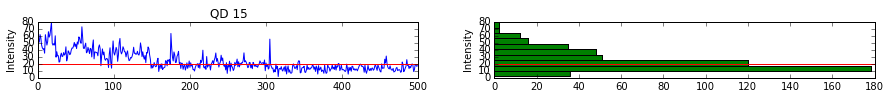

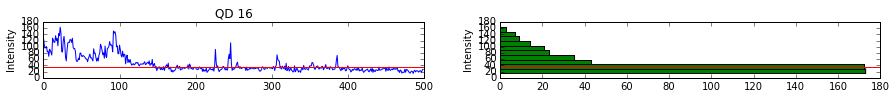

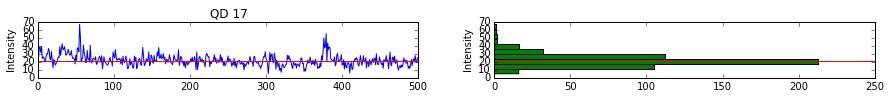

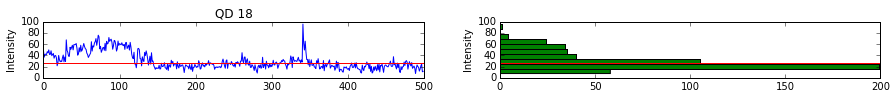

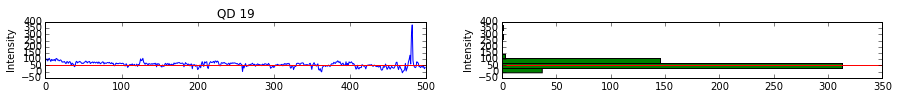

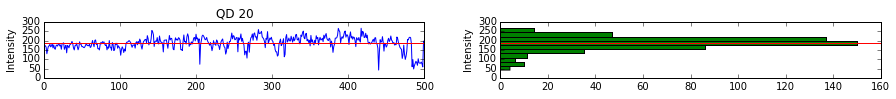

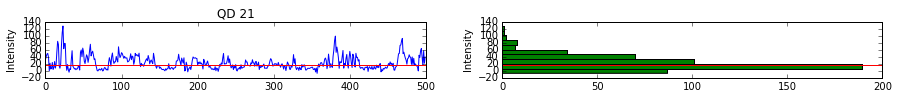

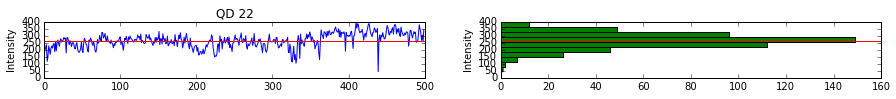

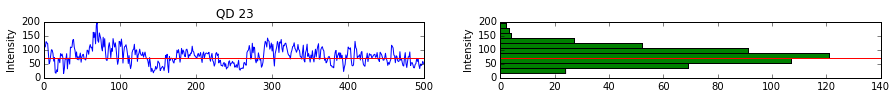

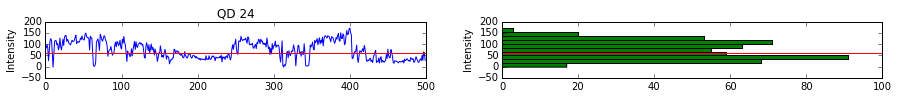

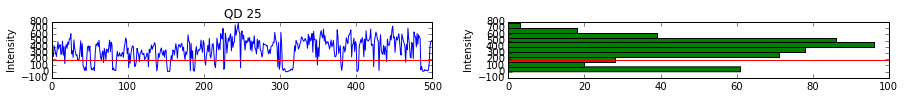

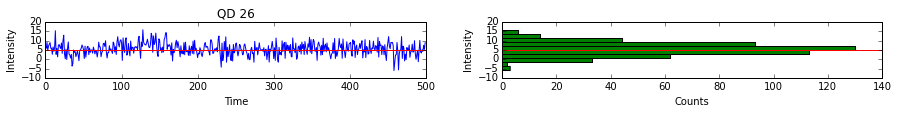

In [38]:
threshold = np.zeros(len(match))
nstd = [ -0.2 ,  1. ,  0.5 ,  1. ,  0.5,  0.5 ,  1. ,  0.1 ,  1. ,  1. ,  1. ,
        0.5 ,  1. ,  1. ,  1.2 ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  -0.1 ,  1. ]
for ip in range(len(match)):
    threshold1 = Ltt[ip].mean()
    for j in range(1):
        off_mean = np.mean([Ltt[ip][i] for i in range(len(Ltt[ip])) if Ltt[ip][i] < threshold1])
        off_std = np.std([Ltt[ip][i] for i in range(len(Ltt[ip])) if Ltt[ip][i] < threshold1], ddof=1, dtype='d')
        threshold1 = off_mean + nstd[ip]*off_std
    threshold[ip] = threshold1
    fig, ax = plt.subplots(1,2, figsize=(15,1))
    ax[0].plot(Ltt[ip], label='QD %d' % ip)
    ax[0].axhline(y=threshold[ip], color='r')
    ax[0].set_title('QD %d' % ip)
    count, bins, patches = ax[1].hist(Ltt[ip], histtype='bar', color='g', orientation='horizontal')
    ax[1].axhline(y=threshold[ip], color='r')
    ax[0].set_ylabel('Intensity')
    ax[1].set_ylabel('Intensity')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Counts')

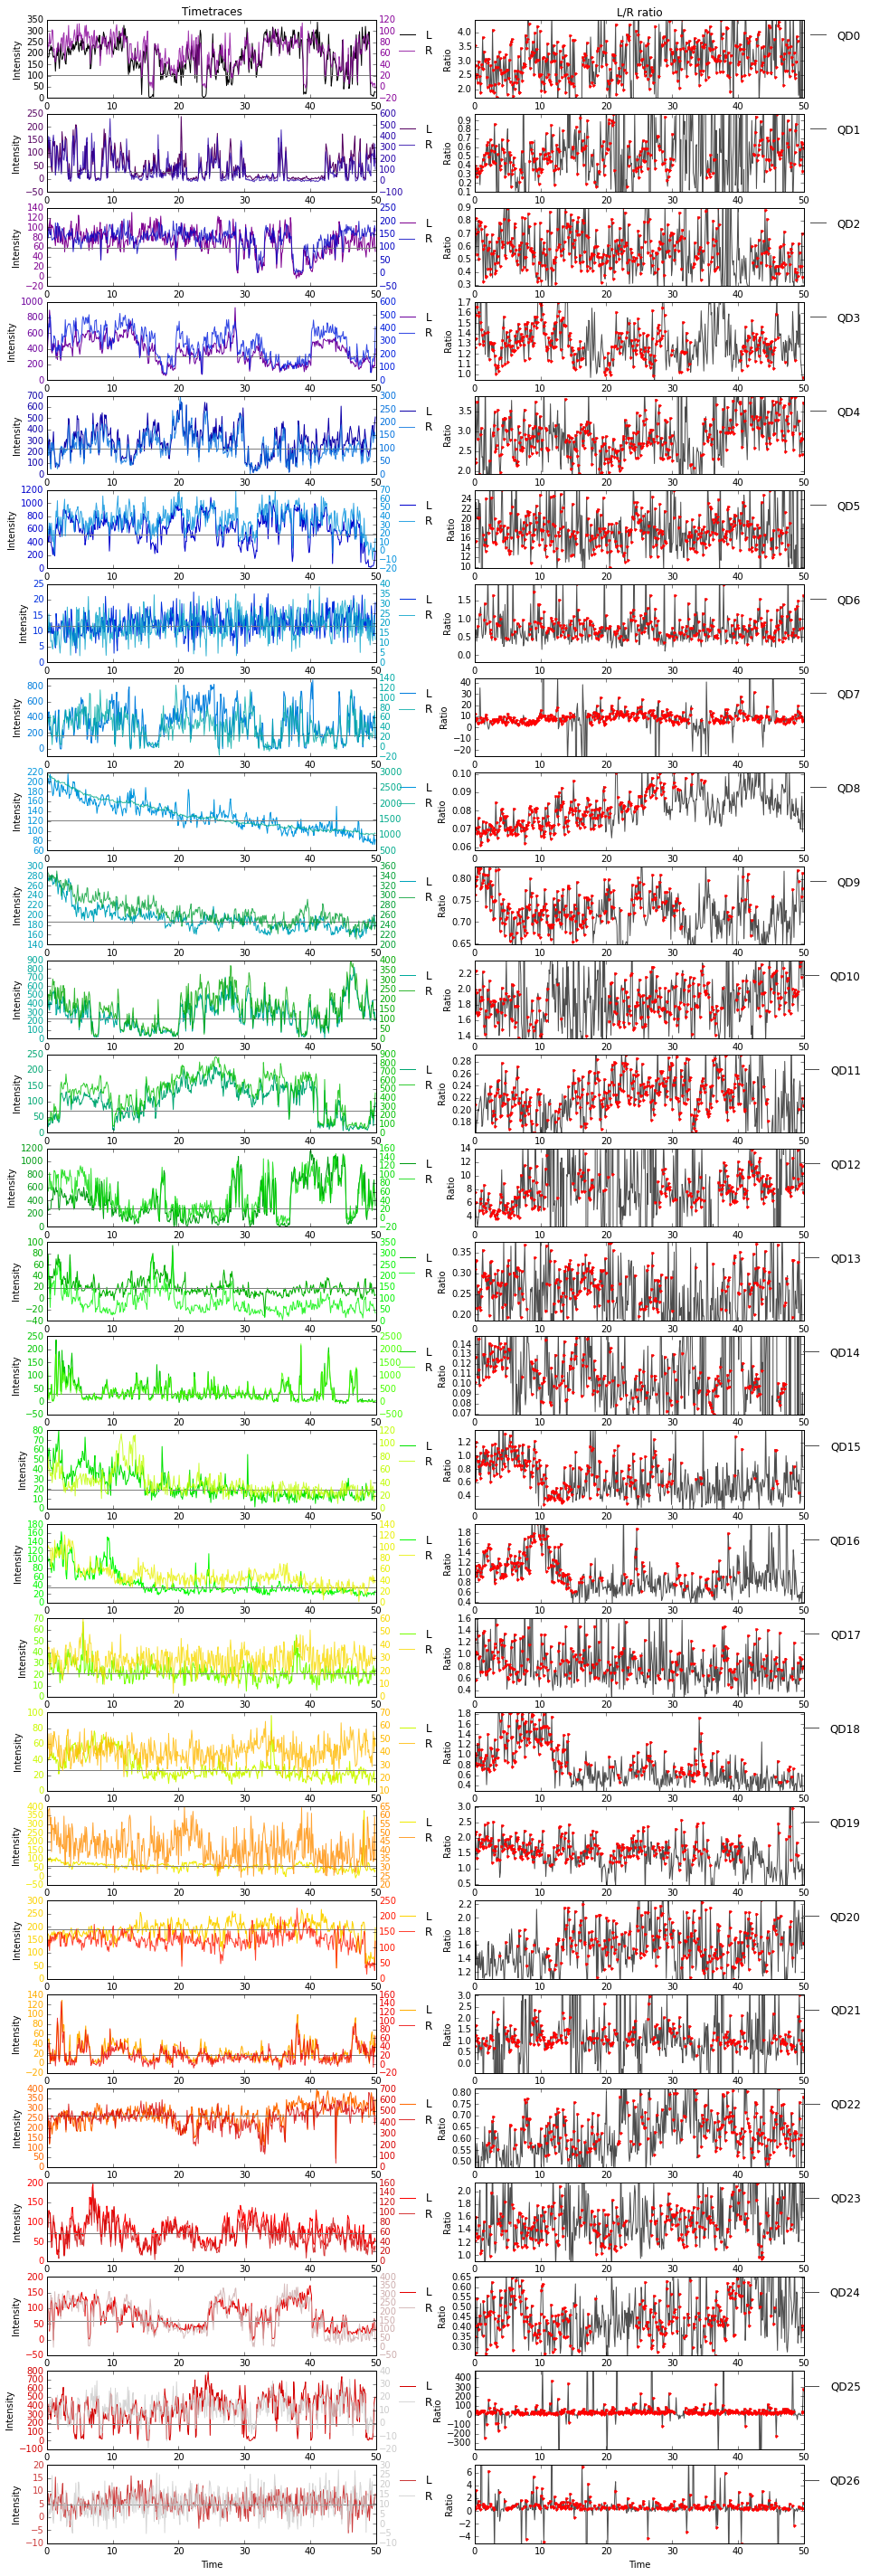

In [43]:
cmap = matplotlib.cm.get_cmap('nipy_spectral')
fig, ax = plt.subplots(len(match),2, figsize=(15,50))
for ip in range(len(match)):
    blink_on_ratio1 = np.array([Ltt[ip][i]/Rtt[ip][i] for i in range(len(Ltt[ip])) if Ltt[ip][i] > threshold[ip]]) 
    T_on = np.array([T[i] for i in range(len(Ltt[ip])) if Ltt[ip][i] > threshold[ip]]) 
    
    ax[ip,0].plot(T, Ltt[ip], c=cmap(float(ip)/len(match)), label='L')
    ax[ip,0].axhline(y = threshold[ip], color='0.5')
    ax2 = ax[ip,0].twinx()
    ax2.plot(T, Rtt[ip], c=cmap(float(ip)/len(match)+0.1), label='R', alpha=0.8)
    for tl in ax[ip,0].get_yticklabels():
        tl.set_color(cmap(float(ip)/len(match)))
    for tl in ax2.get_yticklabels():
        tl.set_color(cmap(float(ip)/len(match)+0.1))
    ax[ip,1].plot(T, Ltt[ip]/Rtt[ip], c='0.3', label='QD%d' % ip)
    ax[ip,1].plot(T_on, blink_on_ratio1, 'r.')
    ax[ip,0].legend(frameon=False, bbox_to_anchor=(1.2,1))
    ax[ip,0].set_ylabel('Intensity')
    ax2.legend(frameon=False, bbox_to_anchor=(1.2,0.8))
    ax[ip,1].legend(frameon=False, bbox_to_anchor=(1.2,1))
    ax[ip,1].set_ylim(np.mean(blink_on_ratio1)-2*np.std(blink_on_ratio1), np.mean(blink_on_ratio1)+2*np.std(blink_on_ratio1))
    ax[ip,1].set_ylabel('Ratio')
    fig.subplots_adjust(wspace=0.3)
    
ax[0,0].set_title('Timetraces')
ax[0,1].set_title('L/R ratio')
ax[ip,0].set_xlabel('Time')
ax[ip,1].set_xlabel('Time')

## Left / right ratio histogram

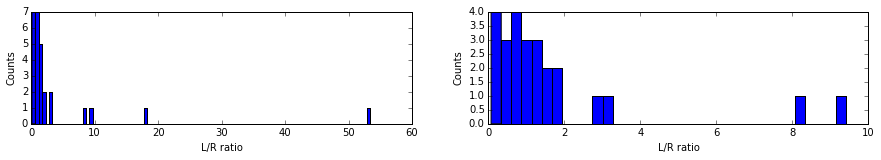

In [33]:
ratio = np.zeros(len(match))
for ip in range(len(match)):
    ratio[ip] = np.mean([Ltt[ip][i]/Rtt[ip][i] for i in range(len(Ltt[ip])) if Ltt[ip][i] > threshold[ip]]) 
fig, ax = plt.subplots(1,2, figsize=(15,2))
hist = ax[0].hist(ratio, bins=100, histtype='bar')
hist = ax[1].hist(ratio, bins=200, histtype='bar')
ax[1].set_xlim(0,10)
ax[0].set_xlabel('L/R ratio')
ax[1].set_xlabel('L/R ratio')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')

## Spectral diffusion autocorrelation

In [76]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result#[result.size/2:]

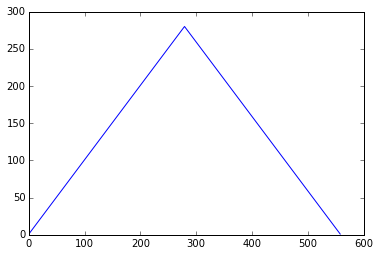

In [94]:
a = np.ones(280)
plt.plot(autocorr(a))

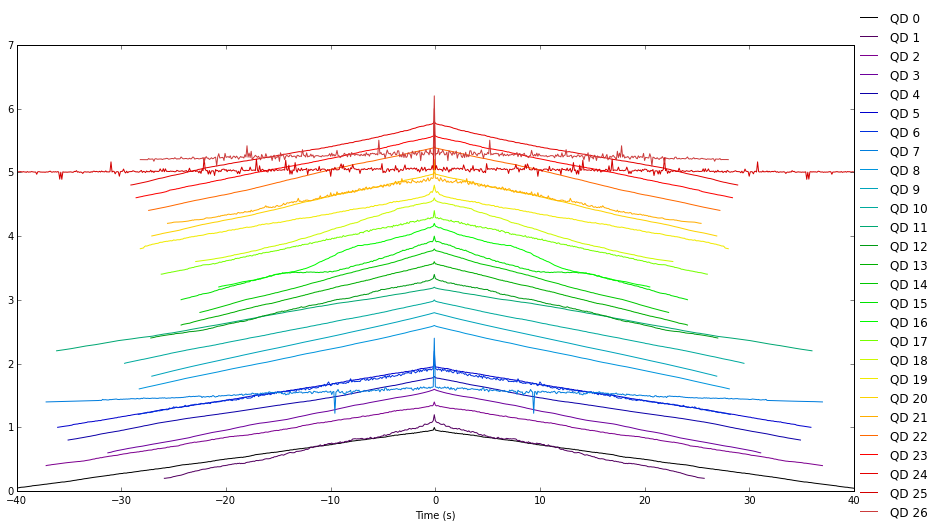

In [93]:
fig, ax = plt.subplots(figsize=(15,8))
for ip in range(len(match)):
    ratio = np.array([Ltt[ip][i]/Rtt[ip][i] for i in range(len(Ltt[ip])) if Ltt[ip][i] > threshold[ip]])
    acrr = autocorr(ratio)
    ax.plot(np.arange(-len(ratio),len(ratio)-1,1)*0.1, acrr/acrr.max()+ip*0.2, '-', 
            color=cmap(float(ip)/len(match)), fillstyle='none', label='QD %d' % ip)
    ax.legend(frameon=False, bbox_to_anchor=(1.1,1.1))
    ax.set_xlabel('Time (s)')
    ax.set_xlim(-40,40)